In [47]:
# Import necessary libraries
import math
import numpy as np

import torch
import torch.nn as nn

## General Architecture of Transformers

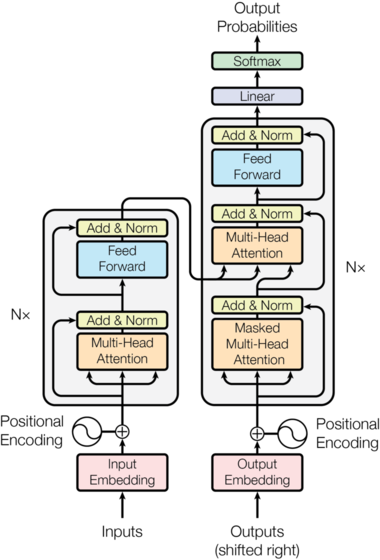

In [48]:
class EncoderDecoder(nn.Module): # nn.Module is base class for all neural networks in pytorch
    """
     general architecture of transformers
    """

    def __init__(self, encoder, decoder, src_embed, target_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.target_embed = target_embed
        self.generator = generator
    

    def encode(self, src, src_mask):
        """
        Module that processes the input (source) sequence and 
        encodes it into a fixed-size representation, often referred to as "memory."

        src_mask : masking result from src for example:
        a = [1,2,3]
        b = [1,2,3,4]

        after mask 

        a = [1,1,1,0]
        b = [1,1,1,1]

        """
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, target, target_mask):
        """
        module that takes the encoded representation from the 
        encoder and the target sequence to generate the final output sequence.

        Arguments:
            memory: The encoded memory from the encode method.
            target: The target sequence.
            target_mask: The mask applied to the target sequence.
        """
        return self.decoder(self.target_embed(target), memory, src_mask, target_mask)


    def forward(self, src, target, src_mask, target_mask):
        """
        Purpose: Defines how the data flows through the network during the forward pass, 
        i.e., when you pass data through the model to get an output.
        """
        return self.decode(self.encode(src, src_mask), src_mask, target, target_mask)
    



output dari decode akan berupa vector yang berukuran d_model, let's say it 512. misal input katanta "i am learning" kita ingin translate ke bahasa indonesia
maka "i am learning" pada layer decode akan punya vektor yang berukuran 512. vektor tersvyt represent input word.

vektor 512 itu perlu diconvert ke dalam distribusi probabilitas dalam vocab. misal vocab nya ada 10.000 kata. inilah yang dilalkukan oleh class Generator. The Generator class will take this vector and produce a 10,000-dimensional vector where each element represents the likelihood of a corresponding word in the vocabulary being the next word in the sentence.

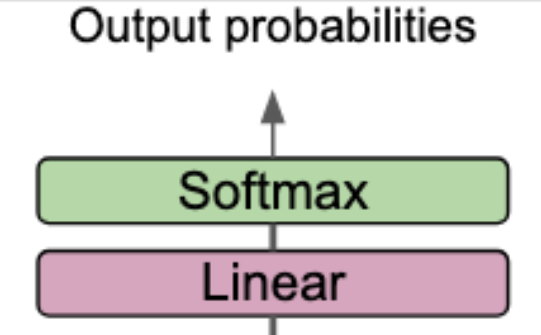

### linear layer

output dari decode layer kan berupa matrix dengan ukuran d_model (512), matrix tersebut akan dilakukan transformasi linear. 

output=W×decoder’s output+b

ukuran hasilnya adalah sejumlah vocab(kata selanjutntya yang bakal diprediksi jadi next word) yang ada pada vocabulary. jadi masing-masing vocab di vocabulary akan punya probabilitasnya masing-masing.

contoh kalau ada 4 vocab dalam vocabulary maka hasil transformasi linearnya adalah vektor dengan ukuran 1 * 4
[0.83, -1.47, 1.52, 0.78]


### softmax layer

Convert linear transformation result into log-probabilities, which can be used to determine the most likely next word in the sequence.

Log-Probabilities= [−1.3975, −3.6975, −0.7075, −1.4475]
​
 



In [49]:
class Generator(nn.Module):

    """
    objective : take output from decoder layer then convert it into probabilities over vocabularies

    d_model : dimentionality of the decoder ouput (vector that represent the input (sentence))
    vocab : the size of possible word to predict
    """
    def __init__(self,d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) # 
    
    def forward(self, x):
        """
        apply linear transformation then put it into softmax

        
        """
        return F.log_softmax(self.proj(x, dim=-1)) 
    

## Encoder

based on original transformer paper, encoder layer consist of N = 6 identical stack layers, so we will build these 6 layer

In [50]:
def clones_layer(module, N):
    """
    function to produce identical layer
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### Layer Normalization

a technique used to stabilize and accelerate the training of deep neural networks. perhitungannya ya gitu2 aja. intinya norm layer ini untuk menormalisasikan output dari masing2 sublayer. norm layer ini selalu ada setelah sub-layer. baik di encodr ,aupun decoder layer.

In [51]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, epsilon=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.epsilon = epsilon

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.epsilon) + self.b_2

create encoder class for each encode layer

In [52]:
class Encoder(nn.Module):
    """
    core encoder layer that consist of N=6 stack layer
    """
    def __init__(self, layer, N):
        self.layers = clones_layer(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):

        """
        define how each input process in encoder layer
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


## Add and Norm Layer

output dari masing masing sublayer, baik multi-head self-attention or feed-forward network, akan ditambahkan dropout(regularization technique to avoid overfiting). lalu outputnya akan digunakan oleh Add (Residual Connection) dengan menambahkannya dengan original input x, baru akan dinormalisasikan oleh proses "norm" melalui layer normalization.


In [53]:
class SublayerConnection(nn.Module):
    
    """
    docs
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size
        """
        return x + self.dropout(sublayer(self.norm(x)))




setiap layer encoder terdiri dari 1 multi-head self-attention mechanism sublayer dan 1 position-wise fully connected feed-forward network sublayer.

In [54]:
class EncoderLayer(nn.Module):
    '''
    Encoder is made up of self-attn and feed forward (defined below)
    '''
    def __init__(self, size, self_attention, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attention = self_attention
        self.feed_forward = feed_forward
        self.sublayer = clones_layer(SublayerConnection(self.size, self.self_attention),2) # masing-masing sublayer terdiri dari 2 sublayer self-attention dan feed forward (MLP)

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attention(x,x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## Decoder

Layer decoder juga terdiri dari 6 identical stack layer.


**MLP == Feed Forward Neural Network**

In [55]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones_layer(layer, N)
        self.norm = LayerNorm(layer.size)


    def forward(self, x, memory, src_mask, target_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, target_mask)
        return self.norm(x)

In [56]:
class DecoderLayer(nn.Module):
    """
    Decoder layer that consist of self-attn, src-attention, and feed forward/MLP
    """
    def __init__(self, size, self_attention, src_attention, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size 
        self.self_attention = self_attention
        self.src_attention =  src_attention
        self.feed_forward = feed_forward
        self.sublayer = clones_layer(SublayerConnection(size, dropout), 3) # masing-masing sublayer terdiri dari 3 sublayer source-attention, self-attention dan feed forward (MLP)

    def forward(self, x, memory, src_mask, target_mask):
        m = memory
        x = self.sublayer[0](x, lambda x : self.self_attention(x,x,x,target_mask))
        x = self.sublayer[1](x,  lambda x : self.src_attention(x, m , m,src_mask))
        return self.sublayer[2](x, self.feed_forward)
    

    

 GATAU INI BUAT APA

In [57]:
def subsequent_mask(size):
    """
    ensuring that predictions for a specific position 𝑖 only depend on the 
    known outputs at positions before 𝑖
    """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

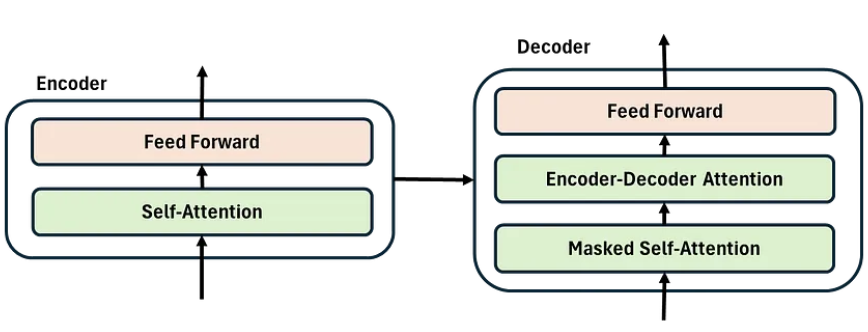

## Self-Attention Mechanism / scaled dot-product attention 

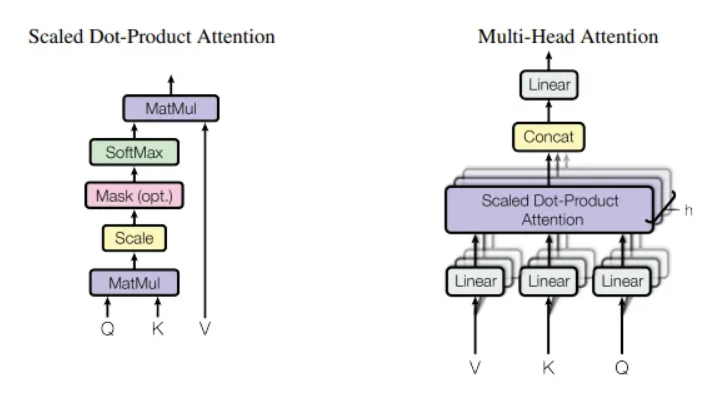

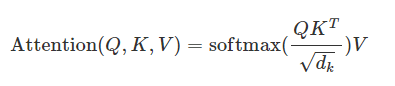

* Q, K, and V are the query, key, and value matrices.
* Square of dk is the dimensionality of the key vectors.
* The softmax function is applied row-wise to normalize the attention scores.
* The division by square of dk is a scaling factor that helps prevent the gradients from becoming too small during backpropagation.

### Key, Query and Value matrices

QUERY

- The query vector represents the element of interest or the context that you want to obtain information about.
- The query vector is used to determine the similarity or relevance between this context and other elements in the input sequence, specifically the key vectors. 


KEY 
- The key vectors are used to compute how relevant each element in the input sequence is to the query.
- This relevance is often calculated using a dot product or another similarity measure between the query and key vectors.

VALUE

- The value vectors store the actual information that will be used to update the representation of the query. These values are weighted by the attention scores (computed from the query-key interaction) to determine how much each element contributes to the final output.
- The attention scores, computed based on the query and key, are used to weight the value vectors. Higher attention scores mean that the corresponding values are more important for the output.


reference 
https://rahulrajpvr7d.medium.com/what-are-the-query-key-and-value-vectors-5656b8ca5fa0

In [59]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Compute 'Scaled Dot Product Attention, between Query, Key and Value
    """

    # size of the last dimension of the query tensor
    d_k = query.size(-1)


    scores = torch.matmul(query, key.transpose(-2, -1))/ math.sqrt(d_k) 
    
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9) # to make the model not consider the future tokens and not influence the attention score computation

    p_attention = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attention = dropout(p_attention)

    return torch.matmul(p_attention, value), p_attention





### example how to calculate self-attention

In [41]:
import torch
import math
import torch.nn.functional as F

# Define query, key, and value tensors for each word in the sentence
query = torch.tensor([[0.1, 0.2, 0.3],  # Encoding for "The"
                      [0.4, 0.5, 0.6],  # Encoding for "cat"
                      [0.7, 0.8, 0.9],  # Encoding for "sat"
                      [0.1, 0.2, 0.3],  # Encoding for "on"
                      [0.4, 0.5, 0.6]]) # Encoding for "the"

key = torch.tensor([[0.1, 0.2, 0.3],  # Encoding for "The"
                    [0.4, 0.5, 0.6],  # Encoding for "cat"
                    [0.7, 0.8, 0.9],  # Encoding for "sat"
                    [0.1, 0.2, 0.3],  # Encoding for "on"
                    [0.4, 0.5, 0.6]]) # Encoding for "the"

value = torch.tensor([[0.1, 0.2, 0.3],  # Value for "The"
                      [0.4, 0.5, 0.6],  # Value for "cat"
                      [0.7, 0.8, 0.9],  # Value for "sat"
                      [0.1, 0.2, 0.3],  # Value for "on"
                      [0.4, 0.5, 0.6]]) # Value for "the"


mask = None
dropout = None


In [44]:
d_k = query.size(-1)
d_k

3

In [35]:
scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
scores

tensor([[0.5774, 0.0000],
        [0.0000, 1.1547]])

In [45]:
p_attn = F.softmax(scores, dim=-1)
p_attn

tensor([[0.1835, 0.2036, 0.2259, 0.1835, 0.2036],
        [0.1594, 0.2067, 0.2680, 0.1594, 0.2067],
        [0.1365, 0.2068, 0.3134, 0.1365, 0.2068],
        [0.1835, 0.2036, 0.2259, 0.1835, 0.2036],
        [0.1594, 0.2067, 0.2680, 0.1594, 0.2067]])

In [46]:
output = torch.matmul(p_attn, value)
output

tensor([[0.3577, 0.4577, 0.5577],
        [0.3848, 0.4848, 0.5848],
        [0.4121, 0.5121, 0.6121],
        [0.3577, 0.4577, 0.5577],
        [0.3848, 0.4848, 0.5848]])

## Multi-head Attention

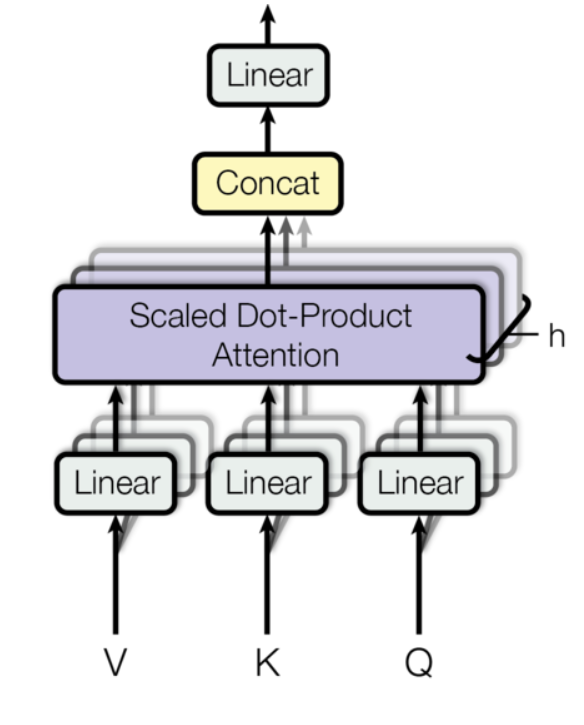

In [60]:
class MultiHeadedAttention(nn.Module):

    def __init__(self,num_head, d_model, dropout = 0.1):
        """
        d_model: This is the dimensionality of the input and output vectors. It represents the size of the model.
        num_head : This is the number of attention heads.   
        d_k : dimension of the key, query, and value vectors for each head. 
        linears : 4 linear transformation layer (look at the multi-head attention figure) 1 for query, 1 for key, 1 for value and 1 concatenated output of the multi-head attention.

        self.attention : softmax of query dot key divide by d_k 
        x : new representation after applying self-attention

        """

        super(MultiHeadedAttention, self).__init__()
        self.num_head = num_head
        self.d_k = d_model//num_head
        self.linears = clones_layer(nn.Linear(d_model, d_model), 4)
        self.attention = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask = None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1. doing linear transformation
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]


        # 2. apply self attention mechanism on all projected vector in batch
        x, self.attention = attention(query, key, value, mask=mask, dropout=self.dropout)


        # 3. concat and doing final linear transformation
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        return self.linears[-1](x)
    